## CNN spectrogram model

* Sliding window
* All annotations

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle, os, sys
from tqdm import tqdm
import tensorflow as tf
import soundfile as sf
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
import librosa.display
import librosa
import torch
import tensorflow_io as tfio
from torch_audiomentations import Gain, AddColoredNoise, PitchShift, Compose
import gc
# Resampling
import scipy.signal as sps
import resampy

repo_base_directory = os.path.dirname(os.getcwd())
sys.path.append(repo_base_directory)
from common.annotation_utils import discretize_all

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [10]:
# ########################## PARAMETER DEFINITION ##########################

#  ************************* Annotation parameters *************************
combined_annotations_filepath = '../audio_annotation/outputs/compiled_annotations_df.parquet'
audio_directory = '../data/audio'
SEGMENT_LENGTH = 2.5
HOP_LENGTH = 0.5
OVERLAP_THRESH = 0.5

#  ************************ Augmentation parameters ************************
AUG_PER_SAMPLE = 1 # 2 means get two augmentations per sample
SHUFFLE_SEED = 0
SR = 22050 # Desired sample rate (if native sampling rate is different, will be resampled with resampy)

#  ************************* Spectrogram parameters ************************
# See: https://stackoverflow.com/questions/62584184/understanding-the-shape-of-spectrograms-and-n-mels
# Number of mel-frequency bands in mel-spectrogram
MEL_BINS = 50
# Lowest and highest frequency (in Hz) to include in mel-scale
F_MIN = 0
F_MAX = 8000 # SR // 2

# FFT_SIZE determines frequency resolution of the window
# in speech processing, the recommended value is 512, corresponding to 23 milliseconds at SR of 22050 Hz
# at SR of 44100, this equals 1024; see https://librosa.org/doc/main/generated/librosa.stft.html#librosa.stft
FFT_SIZE = 1024
FFT_HOP_LENGTH = FFT_SIZE // 4
# Construct matrix to warp linear scale spectrogram to mel scale
MEL_FILTERBANK = tf.signal.linear_to_mel_weight_matrix(num_mel_bins = MEL_BINS,
                                                       num_spectrogram_bins = FFT_SIZE // 2 + 1,
                                                       sample_rate = SR,
                                                       lower_edge_hertz = F_MIN,
                                                       upper_edge_hertz = F_MAX)

In [20]:
def episode_id_to_audio(ep_id, ep_data, audio_directory):
    episode_filepath = os.path.join(audio_directory, ep_id + ep_data['filetype'])
    # fast: if prioritizing speed (over memory)
    if ep_data['filetype'] == '.ogg': #.ogg read is faster in soundfile
        audio, sr = sf.read(episode_filepath)
        audio = np.mean(audio, axis=1)
    elif ep_data['filetype'] == '.mp3': 
        #.mp3 not supported in soundfile, use audioread instead, used in backend of librosa:
        # https://librosa.org/doc/main/_modules/librosa/core/audio.html#load
        audio, sr = librosa.core.audio.__audioread_load(episode_filepath,
                                                        offset = 0, duration = None, dtype=np.float32)  
        audio = np.mean(audio, axis=0)
    if sr != SR:
        audio = resampy.resample(audio, sr, SR)
    return audio, SR

def episode_audio_to_audio_chunks(audio, audio_duration, segment_length, hop_length):
    audio_chunks =  []
    start_times = np.arange(0, audio_duration - segment_length, hop_length)
    for s in start_times:
        start_sample = librosa.time_to_samples(s, sr = SR)
        end_sample = librosa.time_to_samples(s + segment_length, sr = SR)
        sub_audio = audio[start_sample:end_sample]
        audio_chunks.append(sub_audio)
    audio_chunks = np.vstack(audio_chunks)
    #audio_chunks = pad_sequences(audio_chunks, value = 0, padding = 'post')
    return audio_chunks

def discretized_dict_to_dataset(discretized_dict, audio_directory, segment_length, hop_length):
    labels = []
    audio_chunks = []
    ep_ids = []; id2ep = {}; sample_rates = []
    prints = [] # store print statements, so print all episode durations at once 
    
    for idx, ep_id in enumerate(tqdm(discretized_dict)):
        ep_data = discretized_dict[ep_id]
        audio_duration = ep_data['audio_duration']
        ep_audio, ep_sr = episode_id_to_audio(ep_id, ep_data, audio_directory)
        ep_audio_chunks = episode_audio_to_audio_chunks(ep_audio, audio_duration, 
                                                        segment_length, hop_length)
        labels.append(ep_data['y'])
        audio_chunks.append(ep_audio_chunks)
        ep_ids.extend([idx] * len(ep_audio_chunks))
        id2ep[idx] = ep_id
        sample_rates.append(ep_sr)
        prints.append(f"{ep_id} duration: {(len(ep_audio)/ep_sr)/60:.2f} mins \n")
    labels = np.hstack(labels).reshape(-1,1)
    audio_chunks = np.vstack(audio_chunks)
    ep_ids = np.hstack(ep_ids).reshape(-1,1)
    print(f"Sample rates found: {np.unique(sample_rates)}")
    for p in prints:
        print(p)
    return audio_chunks, labels, ep_ids, id2ep

def chunks_and_labels_to_dataset(audio_chunks, labels):
    audio_ds = tf.data.Dataset.from_tensor_slices(audio_chunks)
    label_ds = tf.data.Dataset.from_tensor_slices(labels)
    return tf.data.Dataset.zip((audio_ds, label_ds))

def audio_chunk_to_spectrogram(audio_chunk, mel_filterbank, frame_length, frame_step, sr = SR):
    '''
    References: 
    * https://towardsdatascience.com/how-to-easily-process-audio-on-your-gpu-with-tensorflow-2d9d91360f06
    * https://gist.github.com/keunwoochoi/c9592922a17d71b745d47dc8eb7f0538
    '''
    # Cast waveform to float32
    audio_chunk = tf.cast(audio_chunk, dtype=tf.float32)
    # Convert waveform to spectrogram via STFT, and obtain magnitude
    spectrograms = tf.signal.stft(audio_chunk, frame_length = frame_length, frame_step = frame_step)
    magnitude_spectrograms = tf.abs(spectrograms)
    mel_spectrograms = tf.matmul(tf.square(magnitude_spectrograms), mel_filterbank)
    # Add channels axis:
    mel_spectrograms = mel_spectrograms[..., tf.newaxis]
    return mel_spectrograms

def augment(audio_chunk):
    '''Augment single chunk w Gaussian noise and pitch shift'''
    white_noise = np.random.randn(len(audio_chunk))
    audio_chunk = audio_chunk + 0.01 * white_noise
    pitch_shift_amount = np.random.randn()
    audio_chunk = librosa.effects.pitch_shift(audio_chunk, SR, n_steps=pitch_shift_amount)
    return audio_chunk

# # Initialize augmentor
# torch_augmentor = Compose([
#     PitchShift(p = 1, sample_rate = SR, mode = 'per_example'),
#     Gain(min_gain_in_db = -12, max_gain_in_db = 12, p = 1, mode = 'per_example')
#     #AddColoredNoise(p = 1, mode = 'per_example'),
# ])

# def audio_batch_augmentor(audio_batch, torch_augmentor = torch_augmentor, sr = SR):
#     '''Augmentor that works on batches at train time'''
#     original_shape = audio_batch.shape
#     audio_batch = tf.expand_dims(audio_batch, axis = 1).numpy()
#     batch_aug = torch_augmentor(samples = torch.Tensor(audio_batch), sample_rate = sr)
#     batch_aug = tf.convert_to_tensor(batch_aug.squeeze().numpy())
#     batch_aug.set_shape(original_shape)
#     print(original_shape)
#     return batch_aug

In [4]:
%%capture
_, discretized_dict = discretize_all(combined_annotations_filepath, 
                                     audio_filepath = audio_directory,
                                     segment_length = SEGMENT_LENGTH, 
                                     hop_length = HOP_LENGTH, 
                                     overlap_thresh = OVERLAP_THRESH)
discretized_dict = discretized_dict['data']

all_ep_ids = list(discretized_dict.keys())
train_ep_ids = [i for i in all_ep_ids if i != '1XgTQnRlfJ0zpDdg2DccbR']
test_ep_ids = ['1XgTQnRlfJ0zpDdg2DccbR']
# train_ep_ids = ['0pIwpmg5oPcMWJXVSyrx4E']
# test_ep_ids = ['2DCEgkjSeRQyMt8KovG8vF']

train_dict = { ep_id: discretized_dict[ep_id] for ep_id in train_ep_ids }
test_dict = { ep_id: discretized_dict[ep_id] for ep_id in test_ep_ids }

In [30]:
if os.path.exists('train.npy'):
    with open('train.npy', 'rb') as f:
        train_audio_chunks = np.load(f)
        train_labels = np.load(f)
        train_ep_ids = np.load(f)
else:
    print("Loading train from raw audio...")
    train_audio_chunks, train_labels, train_ep_ids, train_id2ep = discretized_dict_to_dataset(train_dict,
                                                                                              audio_directory,
                                                                                              SEGMENT_LENGTH, 
                                                                                              HOP_LENGTH)
    with open('train.npy', 'wb') as f:
        np.save(f, train_audio_chunks)
        np.save(f, train_labels)
        np.save(f, train_ep_ids)
if os.path.exists('test.npy'):
    with open('test.npy', 'rb') as f:
        test_audio_chunks = np.load(f)
        test_labels = np.load(f)
        test_ep_ids = np.load(f)
else:
    print("Loading test from raw audio...")
    test_audio_chunks, test_labels, test_ep_ids, test_id2ep = discretized_dict_to_dataset(test_dict,
                                                                                          audio_directory,
                                                                                          SEGMENT_LENGTH,
                                                                                          HOP_LENGTH)
    with open('test.npy', 'wb') as f:
        np.save(f, test_audio_chunks)
        np.save(f, test_labels)
        np.save(f, test_ep_ids)

In [ ]:
# Augment

print(f"Original train audio shape: {train_audio_chunks.shape}")
print(f"Original train labels shape: {train_labels.shape}")

train_audio_augs = []
train_label_augs = []

for idx in tqdm(range(len(train_audio_chunks))):
    for n in range(AUG_PER_SAMPLE):
        aug = augment(train_audio_chunks[idx])
        train_audio_augs.append(aug)
        train_label_augs.append(train_labels[idx])

train_audio_augs = np.vstack(train_audio_augs)    
train_label_augs = np.vstack(train_label_augs)

train_audio_chunks = np.vstack([train_audio_chunks, train_audio_augs])
train_labels = np.vstack([train_labels, train_label_augs])

print(f"Augmented train audio shape: {train_audio_chunks.shape}")
print(f"Augmented train labels shape: {train_labels.shape}")

Original train audio shape: (24463, 55125)
Original train labels shape: (24463, 1)


100%|██████████| 24463/24463 [34:05<00:00, 11.96it/s]


In [14]:
# # Debugging
# tf.config.run_functions_eagerly(True)
# blah = episode_id_to_audio('0pIwpmg5oPcMWJXVSyrx4E', 
#                            discretized_dict['0pIwpmg5oPcMWJXVSyrx4E'], 
#                            audio_directory)
# episode_audio_to_audio_chunks(blah[0], 
#                               discretized_dict['0pIwpmg5oPcMWJXVSyrx4E']['audio_duration'],
#                               SEGMENT_LENGTH,
#                               HOP_LENGTH).shape
# plt.plot(blah[0])
# with tf.device('/cpu:0'):
#     train_ds = chunks_and_labels_to_dataset(X_train, y_train)
#     train_ds = train_ds.batch(BATCH_SIZE)
#     single_batch_examples = train_ds.take(1)
#     for sample in single_batch_examples:
#         _chunks, _label = sample[0], sample[1]
#         break
# augment(_chunks)
# audio_batch_augmentor(_chunks)

In [10]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [19]:
with tf.device('/cpu:0'):
    # High batch size is important for imbalanced classes
    BATCH_SIZE = 128
    X_train, X_val, y_train, y_val = train_test_split(train_audio_chunks, train_labels, 
                                                      test_size = 0.2,
                                                      stratify = np.hstack([train_ep_ids, train_labels]),
                                                      shuffle = True,
                                                      random_state = 0)

    X_test, y_test = test_audio_chunks, test_labels

    print(f"X_train: {X_train.shape}")
    print(f"y_train: {y_train.shape}")

    print(f"X_val: {X_val.shape}")
    print(f"y_val: {y_val.shape}")

    print(f"X_test: {X_test.shape}")
    print(f"y_test: {y_test.shape}")

    #tf.py_function(func = get_augmentation, inp = [audio_chunk], Tout = tf.float32)
    train_ds = chunks_and_labels_to_dataset(X_train, y_train)
    train_ds = train_ds.cache().map(
        lambda audio, label: (augment(audio), label),
        num_parallel_calls=tf.data.AUTOTUNE
    ).map( #Transform audio wave to spectrograms
        lambda audio, label: (audio_chunk_to_spectrogram(audio, MEL_FILTERBANK, FFT_SIZE, FFT_HOP_LENGTH), label), 
        num_parallel_calls=tf.data.AUTOTUNE
    ).batch(
        BATCH_SIZE
    ).repeat().prefetch(
        tf.data.AUTOTUNE
    )

    val_ds = chunks_and_labels_to_dataset(X_val, y_val)
    val_ds = val_ds.map(
        lambda audio, label: (audio_chunk_to_spectrogram(audio, MEL_FILTERBANK, FFT_SIZE, FFT_HOP_LENGTH), label), 
        num_parallel_calls=tf.data.AUTOTUNE
    ).batch(
        BATCH_SIZE
    )
    #.prefetch(tf.data.AUTOTUNE)

    # Plot some example spectrograms from a random batch
    n_examples = 3
    fig, axes = plt.subplots(1, n_examples, figsize = (10,3))

    single_batch_examples = train_ds.take(1)

    for sample in single_batch_examples:
        _melspec, _label = sample[0], sample[1]
        _examples = _melspec[:3]
        for i, ax in enumerate(axes.flat):
            print(tf.squeeze(_examples[i]).shape)
            s_dB = librosa.power_to_db(tf.squeeze(_examples[i]), ref=np.max)
            img = librosa.display.specshow(s_dB, x_axis='time', y_axis='mel', sr = SR, ax = ax)
            ax.set_xticks([]);
    fig.tight_layout();

X_train: (19570, 55125)
y_train: (19570, 1)
X_val: (4893, 55125)
y_val: (4893, 1)
X_test: (5626, 55125)
y_test: (5626, 1)


TypeError: in user code:

    File "<ipython-input-17-848a1c5c9cbe>", line 24, in None  *
        lambda audio, label: (augment(audio), label)
    File "<ipython-input-18-0c4471597e40>", line 79, in augment
        white_noise = np.random.randn(audio_chunk.shape)
    File "mtrand.pyx", line 1237, in numpy.random.mtrand.RandomState.randn
        
    File "mtrand.pyx", line 1394, in numpy.random.mtrand.RandomState.standard_normal
        
    File "_common.pyx", line 577, in numpy.random._common.cont
        

    TypeError: 'TensorShape' object cannot be interpreted as an integer


In [11]:
from sklearn.utils import class_weight

EPOCHS = 30
DROPOUT = 0.3

# Based on: https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#setup
# Class imbalance check:
neg, pos = np.bincount(y_train.flatten())
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

initial_bias = np.log([pos/neg])
print(f"Initial bias of classification layer: {initial_bias}\n")

class_weights = dict(enumerate(class_weight.compute_class_weight('balanced', 
                                                                 classes = np.unique(y_train.flatten()),
                                                                 y = y_train.flatten())))
print(f"Class weights: {class_weights}")

model = keras.Sequential(
    [
        layers.Conv2D(filters = 5, kernel_size = (4,4), strides = (1,1), activation="relu", padding = 'same'),
        layers.MaxPooling2D(pool_size = (4,4), strides = (2,2)),
        layers.Dropout(DROPOUT),
        layers.Conv2D(filters = 5, kernel_size = (4,4), strides = (1,1), activation="relu", padding = 'same'),
        layers.MaxPooling2D(pool_size = (4,4), strides = (2,2)),
        layers.Dropout(DROPOUT),
        layers.Conv2D(filters = 5, kernel_size = (4,4), strides = (1,1), activation="relu", padding = 'same'),
        layers.MaxPooling2D(pool_size = (4,4), strides = (2,2)),
        layers.Dropout(DROPOUT),
        layers.Conv2D(filters = 5, kernel_size = (4,4), strides = (1,1), activation="relu", padding = 'same'),
        layers.MaxPooling2D(pool_size = (4,4), strides = (2,2)),
        layers.BatchNormalization(),
        layers.Flatten(),
        layers.Dense(units = 50, activation = "relu"),
        layers.Dense(units = 25, activation = "relu"),
        layers.Dense(units = 1, activation = "sigmoid", 
                     bias_initializer = tf.keras.initializers.Constant(initial_bias))
    ]
)

metrics = ['accuracy', 
           tf.keras.metrics.Precision(name = 'precision'),
           tf.keras.metrics.Recall(name = 'recall'),
           tf.keras.metrics.AUC(name = 'prc', curve = 'PR')]

model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-3),
    loss = tf.keras.losses.BinaryCrossentropy(),
    metrics = metrics
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_prc', 
    verbose = 1,
    patience = 10,
    mode = 'max',
    restore_best_weights = True)

model.predict(train_ds.take(1))

Examples:
    Total: 19570
    Positive: 442 (2.26% of total)

Initial bias of classification layer: [-3.76759863]

Class weights: {0: 0.5115537432036805, 1: 22.138009049773757}


ValueError: in user code:

    File "/home/morrisreeves/anaconda3/envs/morris_capstone/lib/python3.8/site-packages/keras/engine/training.py", line 1621, in predict_function  *
        return step_function(self, iterator)
    File "/home/morrisreeves/anaconda3/envs/morris_capstone/lib/python3.8/site-packages/keras/engine/training.py", line 1611, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/morrisreeves/anaconda3/envs/morris_capstone/lib/python3.8/site-packages/keras/engine/training.py", line 1604, in run_step  **
        outputs = model.predict_step(data)
    File "/home/morrisreeves/anaconda3/envs/morris_capstone/lib/python3.8/site-packages/keras/engine/training.py", line 1572, in predict_step
        return self(x, training=False)
    File "/home/morrisreeves/anaconda3/envs/morris_capstone/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None

    ValueError: Exception encountered when calling layer "sequential" (type Sequential).
    
    Cannot iterate over a shape with unknown rank.
    
    Call arguments received:
      • inputs=tf.Tensor(shape=<unknown>, dtype=float32)
      • training=False
      • mask=None


In [35]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 212, 50, 5)        85        
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 105, 24, 5)       0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 105, 24, 5)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 105, 24, 5)        405       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 51, 11, 5)        0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 51, 11, 5)        

In [36]:
# from https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#setup
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.rcParams["figure.figsize"] = (20,10)

def plot_metrics(history):
    metrics = ['loss', 'prc', 'precision', 'recall']
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,2,n+1)
        plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
        plt.plot(history.epoch, history.history['val_'+metric],
                 color=colors[0], linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == 'loss':
            plt.ylim([0, plt.ylim()[1]])
        elif metric == 'auc':
            plt.ylim([0.8,1])
        else:
            plt.ylim([0,1])
        plt.legend()

In [37]:
history = model.fit(
    train_ds, 
    validation_data = val_ds,  
    epochs = EPOCHS,
    class_weight = class_weights,
    callbacks=[early_stopping]
)

Epoch 1/30
153/153 [==============================] - 65s 389ms/step - loss: 0.9757 - accuracy: 0.6761 - precision: 0.0205 - recall: 0.2851 - prc: 0.0232 - val_loss: 0.6838 - val_accuracy: 0.4241 - val_precision: 0.0239 - val_recall: 0.6126 - val_prc: 0.0201
Epoch 2/30
153/153 [==============================] - 63s 387ms/step - loss: 0.7992 - accuracy: 0.5852 - precision: 0.0212 - recall: 0.3846 - prc: 0.0241 - val_loss: 0.8658 - val_accuracy: 0.3752 - val_precision: 0.0242 - val_recall: 0.6757 - val_prc: 0.0200
Epoch 3/30
153/153 [==============================] - 63s 379ms/step - loss: 0.7649 - accuracy: 0.5807 - precision: 0.0219 - recall: 0.4027 - prc: 0.0250 - val_loss: 0.9490 - val_accuracy: 0.3401 - val_precision: 0.0241 - val_recall: 0.7117 - val_prc: 0.0197
Epoch 4/30
153/153 [==============================] - 62s 376ms/step - loss: 0.7481 - accuracy: 0.5847 - precision: 0.0234 - recall: 0.4276 - prc: 0.0268 - val_loss: 0.9969 - val_accuracy: 0.3066 - val_precision: 0.0232 - v

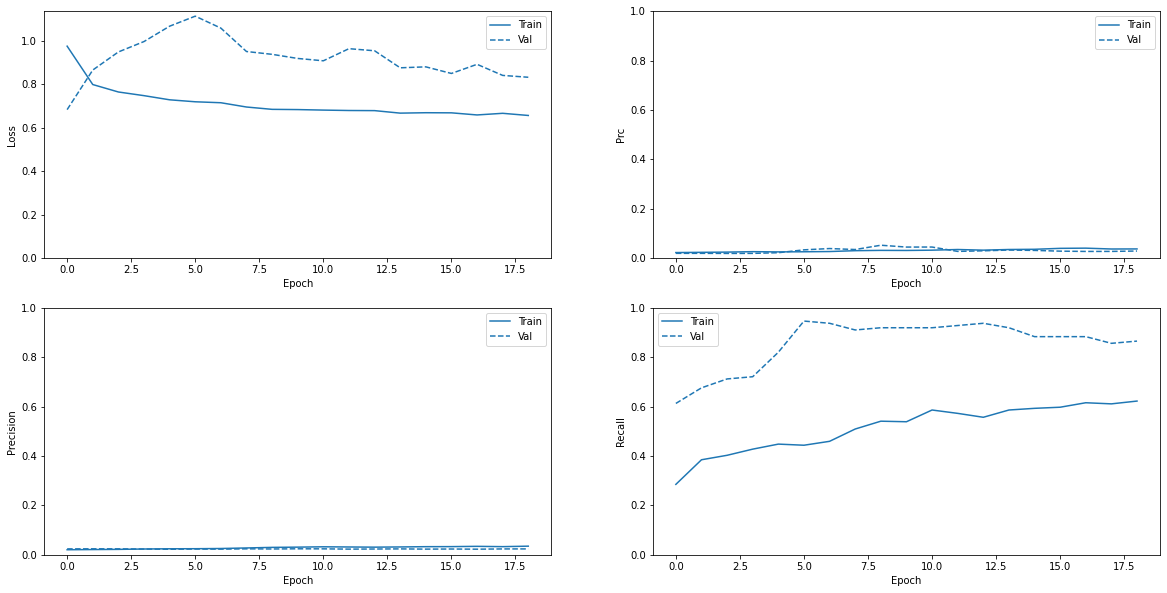

In [38]:
plot_metrics(history);

In [39]:
test_ds = chunks_and_labels_to_dataset(X_test, y_test)
test_ds = test_ds.batch(BATCH_SIZE)

test_ds = test_ds.map(
    lambda x, y: (audio_chunk_to_spectrogram(x, MEL_FILTERBANK, FFT_SIZE, FFT_HOP_LENGTH), y), 
    num_parallel_calls=tf.data.AUTOTUNE
)
test_ds = test_ds.prefetch(tf.data.AUTOTUNE)

In [40]:
results = model.evaluate(test_ds, batch_size = BATCH_SIZE, verbose=1)

44/44 [==============================] - 16s 234ms/step - loss: 0.9705 - accuracy: 0.0611 - precision: 0.0447 - recall: 0.9920 - prc: 0.0594
